# Long Short Term Memory
## A simple guide using keras library 

In this tutorial we will use supernova simulations to train a Recurren Neural Network using LSTM units.

In [2]:
import h5py
import keras 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd

### Load data

In [85]:
filename = './data/supernovae.hdf5'
f = h5py.File(filename, 'r')
light_curves = f['curves'].value
labels       = f['labels'].value
ids          = f['sne_id'].value

I = [1,3,32,33]
labels_new = np.array([0 if l in I else 1 for l in labels ])
multi_class = {1: 0, 2:1, 3:2, 21:3, 22:4, 23:5, 32:6, 33:7}
labels     = np.array([multi_class[l] for l in labels])

<img src="./img/sne_types.png" alt="Girl in a jacket" width="350" height="400"> 

Supernova classes are very unbalanced. A faster way is to group by parent class; It means that we are going to transform a multiclass problem into a binary one.

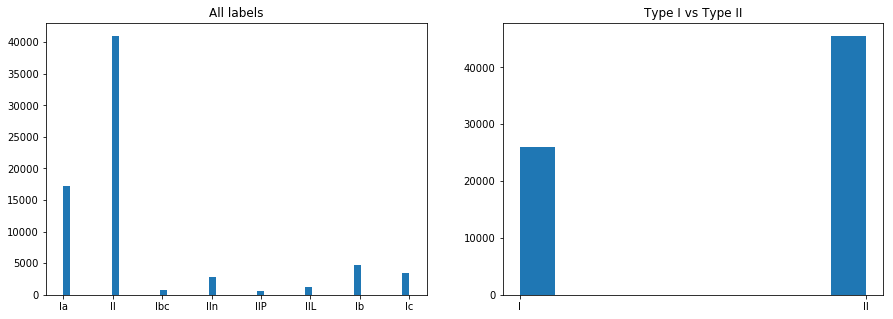

In [87]:
plt.figure(figsize=(15,5))
class_names = ['Ia', 'II', 'Ibc', 'IIn', 'IIP', 'IIL', 'Ib', 'Ic']
binary_names = ['I', 'II']
plt.subplot(121)
plt.hist(labels, bins=50)
plt.title('All labels')
y_pos = np.arange(len(class_names))
plt.xticks(y_pos, class_names)

plt.subplot(122)
plt.hist(labels_new)
plt.title('Type I vs Type II')
y_pos = np.arange(len(binary_names))
plt.xticks(y_pos, binary_names)
plt.show()

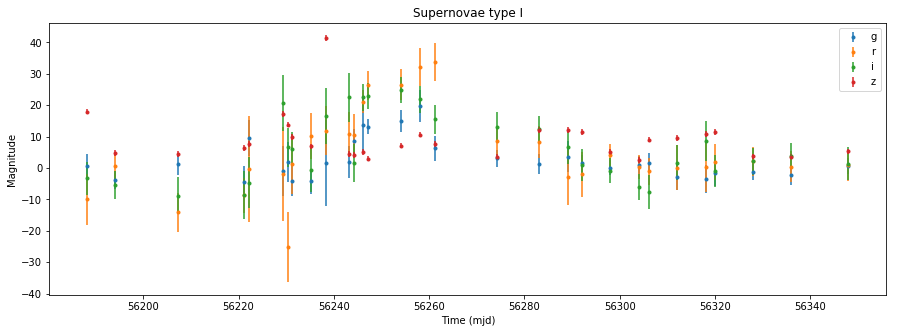

In [88]:
selected = light_curves[labels_new == 0][0]
plt.figure(figsize=(15,5))
plt.errorbar(selected[:,0], selected[:,1], yerr=selected[:,5], label='g', fmt='.')
plt.errorbar(selected[:,0], selected[:,2], yerr=selected[:,6], label='r', fmt='.')
plt.errorbar(selected[:,0], selected[:,3], yerr=selected[:,7], label='i', fmt='.')
plt.errorbar(selected[:,0], selected[:,4], yerr=selected[:,8], label='z', fmt='.')
plt.legend()
plt.xlabel('Time (mjd)')
plt.ylabel('Magnitude')
plt.title('Supernovae type I')
plt.show()

## Data Preprocessing 

In order to avoid the vanish or explode gradient problem we need to scale our data. Preprocessing package from scikit-learn provide a StandarScaler class which normalize the data using the mean and standar deviation for each feature.
<br><br><center>$
\hat{x} = \frac{x - \bar{x}}{\sigma_x}
$<center>

In [45]:
scaler = preprocessing.StandardScaler()
x_scaled = np.array([scaler.fit_transform(x) for x in light_curves])

# One hot encoding 
y_onehot = pd.get_dummies(labels_new).values

In [46]:
np.unique(y_onehot, axis=0)

array([[0, 1],
       [1, 0]], dtype=uint8)

#### Split data to perform training 

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_onehot, test_size=0.3, random_state=42, shuffle=True)
print('Train dimensionality: {}\nTest dimensionality:  {}'.format(x_train.shape, x_test.shape))

Train dimensionality: (50137, 30, 9)
Test dimensionality:  (21488, 30, 9)


## Long Short Term Memory

Using ```Sequential()``` class from *Keras Library* we can stack several layers. In this case, we will use recurrent and dense layer for *the middle learning* and dense activated layer for the output. Remember that the output should have the same dimension as number of classes are considered.<br><br>A graphical representation is shown bellow 

<img src="./img/archi.png" alt="Girl in a jacket" width="700" height="400"> 

In [51]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout, Input
from keras.callbacks import EarlyStopping

In [56]:
# Params 
batch_size   = 128 # Training batch size
n_steps      = x_train.shape[1] # Number of time steps into the serie 
n_channels   = x_train.shape[2] # Number of attributes such as magnitudes and errors
n_classes    = np.unique(labels_new).shape[0] 

n_neurons    = 16  # Neurons in each gate of LSTM

dropout_prob = 0.2 # Fraction of the units to drop 
n_epochs     = 50  # Max number of epochs on training
patience     = 5   # Number of epochs with no improvement

In [59]:
inputs = Input(shape=(n_steps, n_channels))

x = LSTM(n_neurons, return_sequences=True, dropout=dropout_prob)(inputs)
x = LSTM(n_neurons, dropout=dropout_prob)(x)
x = Dense(n_neurons, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30, 9)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 16)            1664      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 34        
Total params: 4,082
Trainable params: 4,082
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(x=x_train,  
                    y=y_train, 
                    batch_size=batch_size, 
                    epochs=n_epochs, 
                    validation_split=0.3,
                    shuffle=True,
                    callbacks = [EarlyStopping(patience=patience)])

Train on 35095 samples, validate on 15042 samples
Epoch 1/50
35095/35095 [==============================] - 9s 258us/step - loss: 0.5253 - acc: 0.7312 - val_loss: 0.3274 - val_acc: 0.8612
Epoch 2/50
35095/35095 [==============================] - 8s 222us/step - loss: 0.3706 - acc: 0.8371 - val_loss: 0.3025 - val_acc: 0.8705
Epoch 3/50
35095/35095 [==============================] - 8s 221us/step - loss: 0.3395 - acc: 0.8547 - val_loss: 0.2915 - val_acc: 0.8782
Epoch 4/50
35095/35095 [==============================] - 11s 308us/step - loss: 0.3220 - acc: 0.8631 - val_loss: 0.2839 - val_acc: 0.8791
Epoch 5/50
35095/35095 [==============================] - 9s 268us/step - loss: 0.3106 - acc: 0.8685 - val_loss: 0.2699 - val_acc: 0.8865
Epoch 6/50
35095/35095 [==============================] - 9s 250us/step - loss: 0.3015 - acc: 0.8736 - val_loss: 0.2502 - val_acc: 0.8984
Epoch 7/50
35095/35095 [==============================] - 9s 246us/step - loss: 0.2944 - acc: 0.8776 - val_loss: 0.2555 -

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
y_probas = model.predict(x_test)
y_pred   = np.argmax(y_probas, axis=1)
y_true   = np.argmax(y_test, axis=1)
acc_test = accuracy_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred, average='macro') 
print('Accuracy:{}\nF1:{}'.format(acc_test, f1_score))

Accuracy:0.9181403574087863
F1:0.9088534801381634


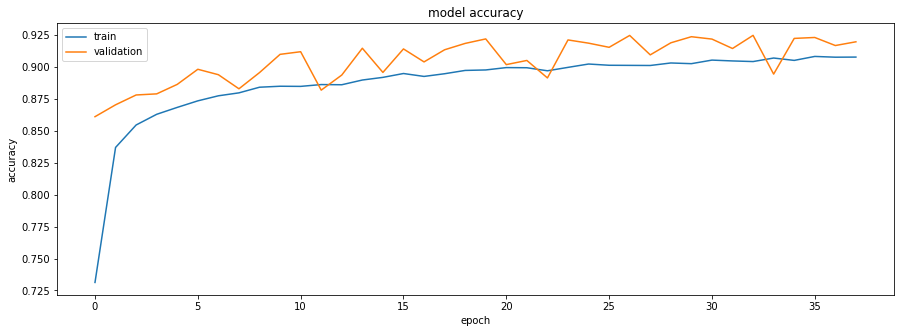

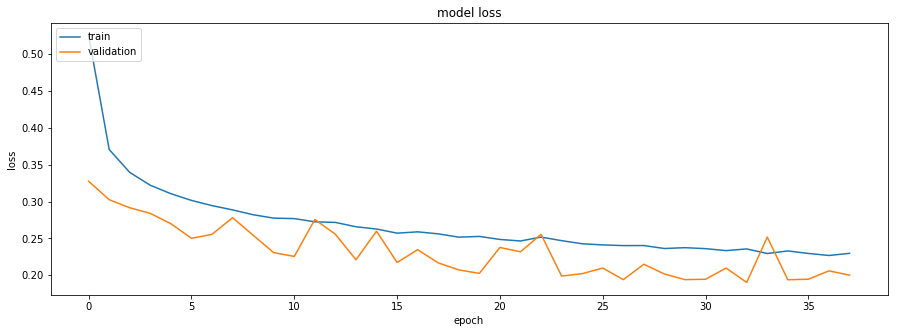

In [66]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

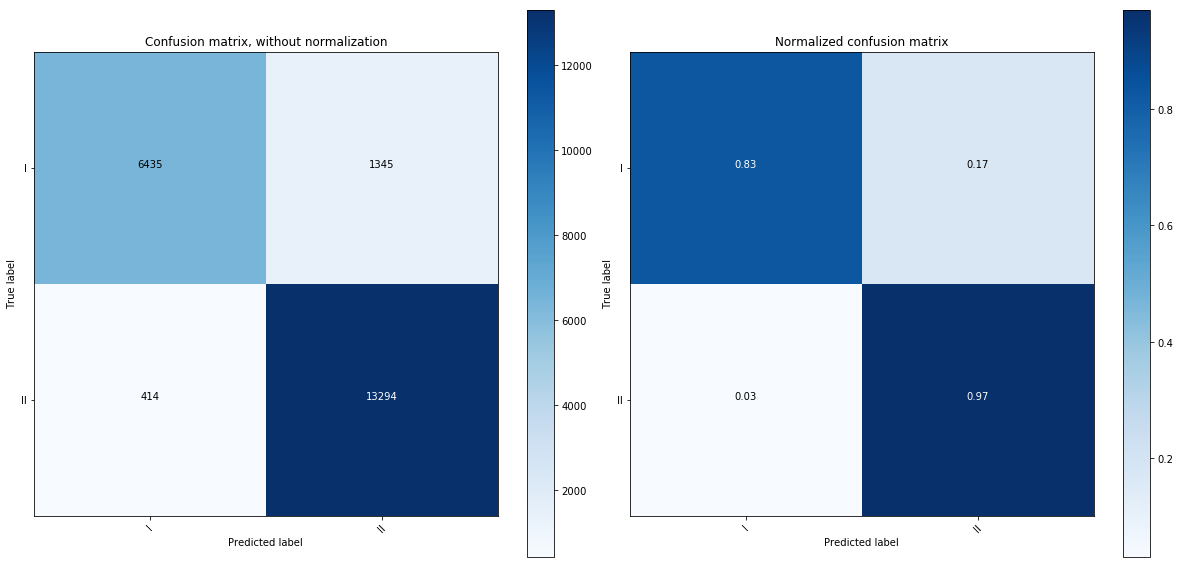

In [68]:
from sklearn.metrics import confusion_matrix
from visual import plot_confusion_matrix
class_names = ['I', 'II']
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(17,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')